# AutoParse demo

In [1]:
from autoparse import AutomatonFitter

## Basic usage

- Define a list of documents and initialize an AutomatonFitter with it
- Fit and build the automaton with .fit_build()
- Execue the automaton on a now documents

In the following demo the documents are generated by two distinct templates:
- PAIEMENT PSC <4-numbers> XXXXX CARTE <8-numbers>
- XXXXX CARTE <8-numbers> PAIEMENT CB <4-numbers> XXXXX

The goal of AutoParse is to infer those two templates from examples and to produce a parser (which is an automaton) that will extract only variable parts (i.e. XXXXX in the templates aboves)

In [2]:
docs = [
    "PAIEMENT PSC 3421 BORDEAUX LA PISCINE CARTE 48392017", 
    "PAIEMENT PSC 5261 PARIS PHIE ITALI CARTE 28495719", 
    "PAIEMENT PSC 9468 LYON LE BON TEMPS CARTE 40273819", 
    "RECEIPT BANK T1 CARTE 39284847 PAIEMENT CB 2807 GB LONDON", 
    "NETFLIX CARTE 40129578 PAIEMENT CB 0602 PARIS",
]

aut_fit = AutomatonFitter(docs)
automaton = aut_fit.fit_build()

In [3]:
automaton.execute("PAIEMENT PSC 2341 LAUSANNE EXPEDIA CARTE 12439751")

('lausanne expedia', {})

In [4]:
automaton.execute("EXPEDIA CARTE 12439751 PAIEMENT CB 2341 LAUSANNE")

('expedia lausanne', {})

In [5]:
automaton.execute("THIS IS NOT GENERATED BY ONE OF THE TWO TEMPLATES")

('this is not generated by one of the two templates', {})

## Parameters

### Threshold

The threshold (between 0 and 1) should be lower than the lowest frequency of a template among the training set of documents. In the following example the two templates have a frequency of respectively 0.6 and 0.4, thus the threshold can be between 0 and 0.4

In [6]:
docs = [
    "PAIEMENT PSC 3421 BORDEAUX LA PISCINE CARTE 48392017", 
    "PAIEMENT PSC 5261 PARIS PHIE ITALI CARTE 28495719", 
    "PAIEMENT PSC 9468 LYON LE BON TEMPS CARTE 40273819", 
    "RECEIPT BANK T1 CARTE 39284847 PAIEMENT CB 2807 GB LONDON",
    "NETFLIX CARTE 40129578 PAIEMENT CB 0602 PARIS",
]

aut_fit = AutomatonFitter(docs)
automaton = aut_fit.fit_build(0.3)
print("Good choise of threshold:")
automaton.execute("EXPEDIA CARTE 12439751 PAIEMENT CB 2341 LAUSANNE")

Good choise of threshold:


('expedia lausanne', {})

In [7]:
aut_fit = AutomatonFitter(docs)
automaton = aut_fit.fit_build(0.5)
print("Bad choise of threshold:")
automaton.execute("EXPEDIA CARTE 12439751 PAIEMENT CB 2341 LAUSANNE")

Bad choise of threshold:


('expedia paiement cb 2341 lausanne', {})

<br/>

If some words have an higer frequency than the threshold may be integrated in the template, and thus not retrieved anymore when executing the automaton

In [8]:
docs = [
    "PAIEMENT PSC 3421 PARIS LA PISCINE CARTE 48392017", 
    "PAIEMENT PSC 5261 PARIS PHIE ITALI CARTE 28495719", 
    "PAIEMENT PSC 9468 PARIS LE BON TEMPS CARTE 40273819", 
    "RECEIPT BANK T1 CARTE 39284847 PAIEMENT CB 2807 LONDON",
    "NETFLIX CARTE 40129578 PAIEMENT CB 0602 PARIS",
]

aut_fit = AutomatonFitter(docs)
automaton = aut_fit.fit_build(0.30)
print("'Paris' has a frequency higher than the threshold and is not retrieved:")
automaton.execute("PAIEMENT PSC 2341 PARIS EXPEDIA CARTE 12439751")

'Paris' has a frequency higher than the threshold and is not retrieved:


('expedia', {})

### Word Black List

If a word has an higher frequency than one of the template there is no good choice for the threshold. This can be solved by adding the given word to the blacklist

In [9]:
aut_fit = AutomatonFitter(docs)
automaton = aut_fit.fit_build(0.30, word_black_list=['PARIS'])
print("'Paris' has a frequency higher than the threshold but is blacklisted:")
automaton.execute("PAIEMENT PSC 2341 PARIS EXPEDIA CARTE 12439751")

'Paris' has a frequency higher than the threshold but is blacklisted:


('paris expedia', {})

### Min Freq

When fitting an automaton on hundred or thousand of documents there may be outliers, it is possible to get rid of them by setting the min_freq to a value higher than the frequency of these outlayer. This may help reducing the complexity of the automaton.

Example: 
```python
aut_fit.fit_build(0.30, min_freq = 0.001)
```

## Extracting variables

It is possible to guess which word correspond to which type of variables given a list of examples. For isntance if we cant to retrieve the city out of a document we can train the automaton with a list of the most frequent cities:

In [10]:
docs = [
    "PAIEMENT PSC 3421 PARIS LA PISCINE CARTE 48392017", 
    "PAIEMENT PSC 5261 PARIS PHIE ITALI CARTE 28495719", 
    "PAIEMENT PSC 9468 LONDON LE BON TEMPS CARTE 40273819", 
    "PAIEMENT PSC 2341 LAUSANNE EXPEDIA CARTE 12439751",
    "PAIEMENT PSC 2341 LONDON NETFLIX CARTE 12439751",
]

aut_fit = AutomatonFitter(docs, variables={"city": ["PARIS", "LONDON"]})
automaton = aut_fit.fit_build(0.50)
print("'LAUSANNE' was not given as example but it has the same role as 'PARIS' and 'LONDON':")
automaton.execute("PAIEMENT PSC 2341 LAUSANNE CARREFOUR CARTE 12439751")

'LAUSANNE' was not given as example but it has the same role as 'PARIS' and 'LONDON':


('lausanne carrefour', {'city': 'lausanne'})

<br/>

This feature is still experimental, it can't retrieve multiple words values and may have trouble to make a prediction when the variable is not enclose between fixed parts.

For instance if the template looks like this:  
PAIEMENT PSC XXXX <$city> XXXX CARTE

because XXXX may be replaced by a variable number of words the automaton may be mislead.

## Setting the order of the markov model

Sometimes more than one path through the automaton will be matched by a document, to decide which one should be returned we compute the likelihood of each of those path given the training data. This is done using a markov model, the parameter `order` stand for the amount of memory used to compute the probability of the next transition.

Thus setting
```python
aut_fit = AutomatonFitter(docs, order=3)
```

will compute the probability of each transition using the last 3 states visited.

## Visualisation

The automaton can be inspected at any time using either method print() or pprint() (pretty print)

Before fitting:


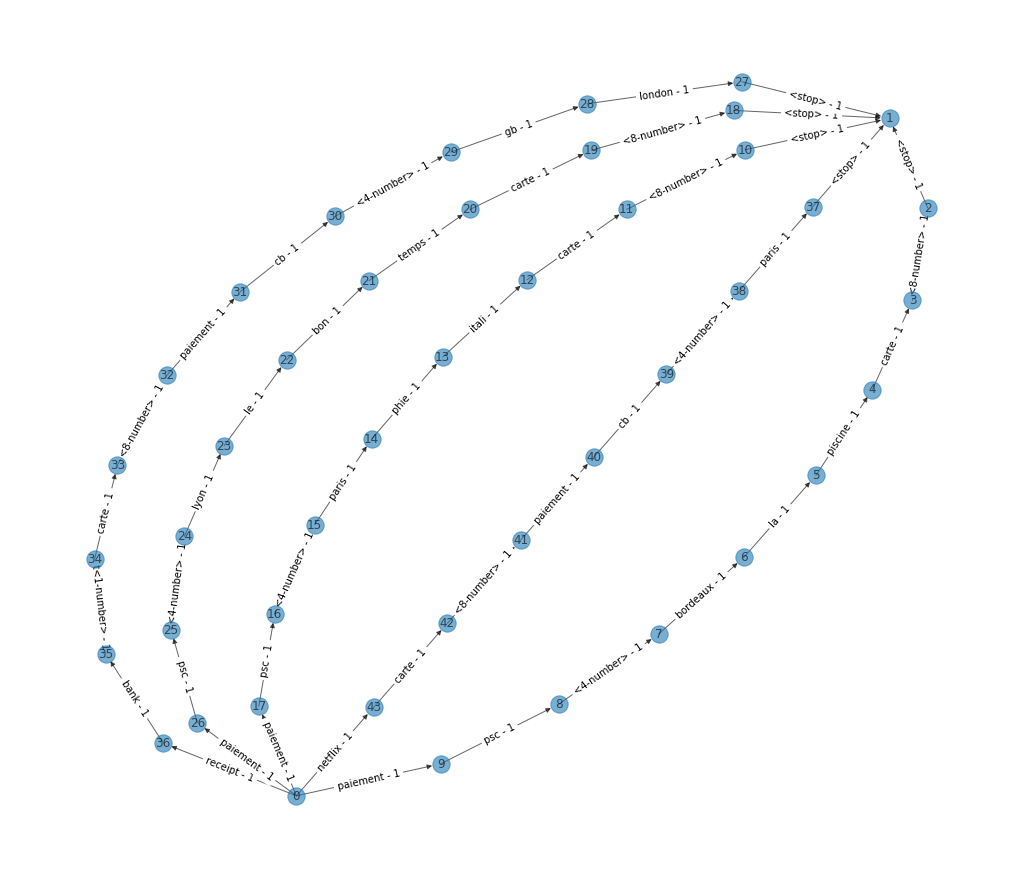

In [11]:
docs = [
    "PAIEMENT PSC 3421 BORDEAUX LA PISCINE CARTE 48392017", 
    "PAIEMENT PSC 5261 PARIS PHIE ITALI CARTE 28495719", 
    "PAIEMENT PSC 9468 LYON LE BON TEMPS CARTE 40273819", 
    "RECEIPT BANK T1 CARTE 39284847 PAIEMENT CB 2807 GB LONDON", 
    "NETFLIX CARTE 40129578 PAIEMENT CB 0602 PARIS",
]

aut_fit = AutomatonFitter(docs)
print("Before fitting:")
aut_fit.pprint()

After fitting


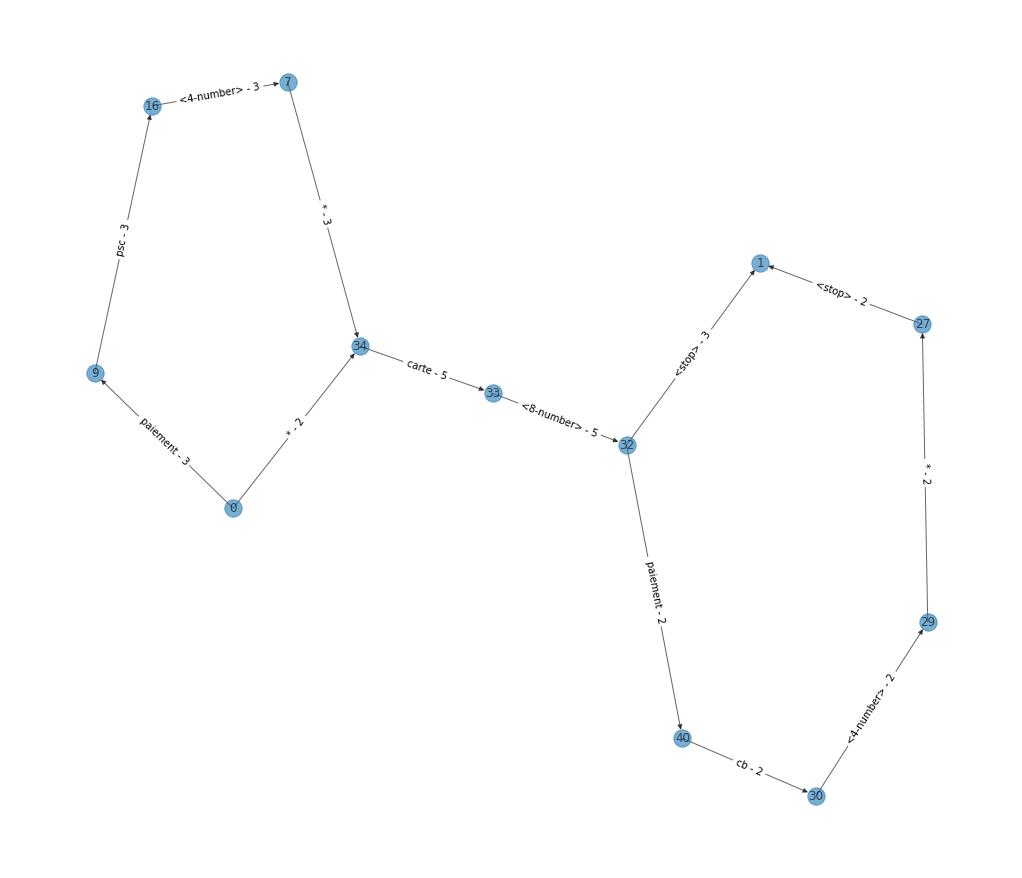

In [12]:
aut_fit.fit()
print("After fitting")
aut_fit.pprint()

The executable automaton can also be inspected by plotting the transitions

In [13]:
automaton = aut_fit.build()
print(automaton)

0 --paiement--> 9
0 --*--> 34
27 --*--> 27
27 --<stop>--> 1
32 --<stop>--> 1
32 --paiement--> 40
33 --<8-number>--> 32
34 --*--> 34
34 --carte--> 33
7 --*--> 34
16 --<4-number>--> 7
9 --psc--> 16
29 --*--> 27
30 --<4-number>--> 29
40 --cb--> 30
